In [1]:
from mlxtend.data import loadlocal_mnist
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle

%matplotlib inline
np.random.seed(1)

### 1. Get Data

In [2]:
def load_dataset():
    X_train, y_train = loadlocal_mnist(
        images_path='/Users/dibu/Gatech Academics/BigDataSystems-CS6220/Assignments/A1/workspace/MNIST_dataset/train-images-idx3-ubyte', 
        labels_path='/Users/dibu/Gatech Academics/BigDataSystems-CS6220/Assignments/A1/workspace/MNIST_dataset/train-labels-idx1-ubyte')
    
    X_test, y_test = loadlocal_mnist(
        images_path='/Users/dibu/Gatech Academics/BigDataSystems-CS6220/Assignments/A1/workspace/MNIST_dataset/t10k-images-idx3-ubyte', 
        labels_path='/Users/dibu/Gatech Academics/BigDataSystems-CS6220/Assignments/A1/workspace/MNIST_dataset/t10k-labels-idx1-ubyte')
    
    X_train = X_train.reshape(60000,28,28)
    X_test = X_test.reshape(10000,28,28)
    return X_train, y_train, X_test, y_test

In [3]:
def convert_to_onehot(X, num_classes):
    num_classes = tf.constant(num_classes, name="num_classes")
    one_hot_matrix = tf.one_hot(X, depth= num_classes, axis= 1)
    session = tf.Session()
    X_one_hot = session.run(one_hot_matrix)
    session.close()
    return X_one_hot

(28, 28)
(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


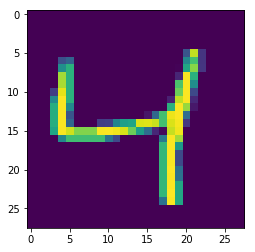

In [4]:
num_classes = 10
X_train, y_train, X_test, y_test = load_dataset()
print(X_train[0].shape)
plt.imshow(X_train[2])
y_train = convert_to_onehot(y_train, num_classes)
y_test = convert_to_onehot(y_test, num_classes)
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

# X_train = np.expand_dims(X_train, axis=1).transpose(0,2,3,1)
# X_test = np.expand_dims(X_test, axis=1).transpose(0,2,3,1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

### 2- Sample Data
(Train Data: Test Data) == (80:20)

In [5]:
sample = np.random.randint(low=0, high=60000, size=10000)
X_train_sample = X_train[sample]
Y_train_sample = y_train[sample]


sample = np.random.randint(low=0, high=10000, size=2000)
X_test_sample = X_test[sample]
Y_test_sample = y_test[sample]

print("X_train Sample shape: "+ str(X_train_sample.shape))
print("Y_train Sample shape: "+ str(Y_train_sample.shape))
print("X_test Sample shape: "+ str(X_test_sample.shape))
print("Y_test Sample shape: "+ str(Y_test_sample.shape))



X_train Sample shape: (10000, 28, 28, 1)
Y_train Sample shape: (10000, 10)
X_test Sample shape: (2000, 28, 28, 1)
Y_test Sample shape: (2000, 10)


### 3 -  Tensorflow Forward Pass


In [6]:
def create_placeholders(n_H0, n_W0,n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    return X, Y

### 4 - Initialize Filters


In [7]:
def initialize_parameters():
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [4,4,1,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

### 5- Forward Propagation


In [8]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    #Conv2d
#     print(X.shape)
#     print(W1.shape)
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
#     print(Z1.shape)
    # RELU
    A1 = tf.nn.relu(Z1)
#     print(A1.shape)
    # MAXPOOL
    P1 = tf.nn.max_pool(A1, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
#     print(P1.shape)
    # CONV2D
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
#     print(Z2.shape)
    # RELU
    A2 = tf.nn.relu(Z2)
#     print(A2.shape)
    # MAXPOOL
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides= [1,4,4,1], padding='SAME')
    # FLATTEN
#     print(P2.shape)
    P2 = tf.contrib.layers.flatten(P2)
#     print(P2.shape)
    # FULLY-CONNECTED 
    Z3 = tf.contrib.layers.fully_connected(P2, 10, activation_fn=None)
#     print(Z3.shape)

    return Z3

### 6 - Compute Cost

In [9]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

### 7 - Build Model

In [10]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [11]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 100, minibatch_size = 200, print_cost = True):
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0,n_C0) = X_train.shape    
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

### 8 - Compute Run time and Accuracy

In [14]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    _, _, parameters = f(*args)
    toc = time.time()
    return toc - tic

(?, 28, 28, 1)
(4, 4, 1, 8)
(?, 28, 28, 8)
(?, 28, 28, 8)
(?, 7, 7, 8)
(?, 7, 7, 16)
(?, 7, 7, 16)
(?, 2, 2, 16)
(?, 64)
(?, 10)
Cost after epoch 0: 41.523057
Cost after epoch 5: 2.857200
Cost after epoch 10: 1.227229
Cost after epoch 15: 0.762666
Cost after epoch 20: 0.553723
Cost after epoch 25: 0.444633
Cost after epoch 30: 0.367639
Cost after epoch 35: 0.313833
Cost after epoch 40: 0.274455
Cost after epoch 45: 0.244919
Cost after epoch 50: 0.220809
Cost after epoch 55: 0.201495
Cost after epoch 60: 0.185798
Cost after epoch 65: 0.174723
Cost after epoch 70: 0.159564
Cost after epoch 75: 0.147618
Cost after epoch 80: 0.134792
Cost after epoch 85: 0.127297
Cost after epoch 90: 0.119894
Cost after epoch 95: 0.110158


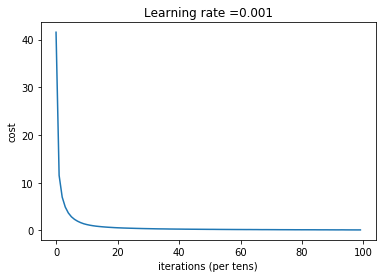

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9708
Test Accuracy: 0.9435


In [16]:
execution_time = time_function(model, X_train_sample, Y_train_sample, X_test_sample, Y_test_sample)

In [17]:
print("Execution Time: " + str(execution_time) + " sec")

Execution Time: 282.98481607437134 sec
